# Challenge!!

### Directions
Gather at least five images of different file extensions. Identify which of these are readable by OpenCV using cv2.imread. Check and validate using cv2.imshow. Save each images into different file extension. Submit a zip file compilation of this challenge and rename the folder with "LAST, First MI" format (DHARMA, John Michael A)

In [42]:
## import cv2
import os
import shutil

input_folder = "./images/"
output_folder = "./GARCIA, Joseph Jeremy C/"
os.makedirs(output_folder, exist_ok=True)

images = [
    "test1.jpg",
    "test2.png",
    "test3.bmp",
    "test4.tiff",
    "test5.webp"
]

try:
    import tkinter as tk
    root = tk.Tk()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
except:
    screen_width, screen_height = 1366, 768

window_width, window_height = 600, 400

for i, filename in enumerate(images, start=1):
    path = os.path.join(input_folder, filename)
    print(f"\nProcessing: {path}")
    img = cv2.imread(path)

    if img is None:
        print(f"Could not read {filename}")
        continue

    print(f"Successfully read {filename}, Shape: {img.shape}")
    win_name = f"Image Viewer"
    cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(win_name, window_width, window_height)

    resized = cv2.resize(img, (window_width, window_height))

    x = (screen_width - window_width) // 2
    y = (screen_height - window_height) // 2
    cv2.moveWindow(win_name, x, y)

    cv2.imshow(win_name, resized)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    save_path = os.path.join(output_folder, f"converted_{i}.png")
    cv2.imwrite(save_path, img)
    print(f"Saved {filename} as {save_path}")

# zip_filename = "GARCIA, Joseph Jeremy C"
# shutil.make_archive(zip_filename, 'zip', output_folder)
# print(f"\nZIP file created: {zip_filename}.zip")



Processing: ./images/test1.jpg
Successfully read test1.jpg, Shape: (1080, 1920, 3)
Saved test1.jpg as ./GARCIA, Joseph Jeremy C/converted_1.png

Processing: ./images/test2.png
Successfully read test2.png, Shape: (266, 474, 3)
Saved test2.png as ./GARCIA, Joseph Jeremy C/converted_2.png

Processing: ./images/test3.bmp
Successfully read test3.bmp, Shape: (720, 1280, 3)
Saved test3.bmp as ./GARCIA, Joseph Jeremy C/converted_3.png

Processing: ./images/test4.tiff
Successfully read test4.tiff, Shape: (720, 1280, 3)
Saved test4.tiff as ./GARCIA, Joseph Jeremy C/converted_4.png

Processing: ./images/test5.webp
Successfully read test5.webp, Shape: (1280, 961, 3)
Saved test5.webp as ./GARCIA, Joseph Jeremy C/converted_5.png


# Challenge

#### Directions: 
1. Load an image.  Create a filter (as a function) for images, similar to what your present in your cameras. Show and compare each images using different filters you created. Be creative and imaginative. Make sure that the filter adjusts/ corrects the original image.
2. Create or load a grayscale image object. Try to revert it back to an assumed three-channeled image. Tip: Create individual layers and then combine. Additional Tip: You are free to use different values for RGB as long as it should return back to the original grayscale image.
3. Convert and save a BnW image from the grayscale image you created. Save the file as BnW - SURNAME, FirstName.

#### Activity
1. Differentiate RGB and HSV. What do these things do? Is it possible to have one but not the other? 
2. Can I convert HSV images to RGB and vice versa?
3. How are filters useful in image manipulation

In [5]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog, simpledialog, ttk, messagebox
from PIL import Image, ImageTk
import os
import time
import shutil

SAVE_DIR = "BoothShots"
FRAMES_DIR = "Frames"
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(FRAMES_DIR, exist_ok=True)


class PhotoBooth:
    def __init__(self, root):
        self.root = root
        self.root.title("📸 Photobooth")
        self.images = []
        self.current_collage = None
        self.grid_count = 1
        self.collage_counter = 1   # To auto-increment saved collages
        self.frame_counter = tk.IntVar(value=1)
        self.uploaded_frame_path = None
        self.frame_file = None

        style = ttk.Style()
        style.configure("TButton", font=("Arial", 12), padding=10)
        style.configure("TLabel", font=("Arial", 14))

        header = tk.Frame(root, bg="#222", height=50)
        header.pack(fill="x")
        tk.Label(header, text="📸 Photobooth", bg="#222", fg="white",
                 font=("Arial", 16, "bold")).pack(pady=10)

        menu = tk.Frame(root, pady=20)
        menu.pack()

        ttk.Button(menu, text="📷 Take Photo", width=25, command=self.take_photo).pack(pady=5)
        ttk.Button(menu, text="🖼 Load Image", width=25, command=self.load_image).pack(pady=5)
        ttk.Button(menu, text="🎨 Frame Design", width=25, command=self.open_frame_designer).pack(pady=5)
        ttk.Button(menu, text="❌ Exit", width=25, command=root.quit).pack(pady=5)

        self.center_window(self.root, 400, 350)

    def center_window(self, win, w, h):
        """Centers any Tkinter window on screen."""
        win.update_idletasks()
        ws = win.winfo_screenwidth()
        hs = win.winfo_screenheight()
        x = (ws // 2) - (w // 2)
        y = (hs // 2) - (h // 2)
        win.geometry(f"{w}x{h}+{x}+{y}")

    def ask_grid_count(self):
        return simpledialog.askinteger("Grids", "How many grids do you want? (1–6)",
                                       minvalue=1, maxvalue=6) or 1

    def take_photo(self):
        self.grid_count = self.ask_grid_count()
        if self.grid_count < 1:
            return
        self.images = []

        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            messagebox.showerror("Camera Error", "Cannot open camera.")
            return

        warm_start = time.time()
        while time.time() - warm_start < 0.5:
            cap.read()

        cancelled = False
        countdown_seconds = 5 

        for i in range(self.grid_count):
            end_time = time.time() + countdown_seconds
            while True:
                ret, frame = cap.read()
                if not ret:
                    cancelled = True
                    break

                remaining = int(max(0, end_time - time.time()))
                msg = f"Shot {i+1}/{self.grid_count} - Capturing in {remaining} sec"
                temp = frame.copy()
                cv2.putText(temp, msg, (30, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                cv2.imshow("Photobooth - Timer (press ESC to cancel)", temp)

                key = cv2.waitKey(30) & 0xFF
                if key == 27:  
                    cancelled = True
                    break

                if time.time() >= end_time:
                    break

            if cancelled:
                break

            final_frame = None
            for _ in range(3):
                ret, f = cap.read()
                if ret:
                    final_frame = f.copy()
                cv2.waitKey(50)

            if final_frame is not None:
                self.images.append(final_frame)

        cap.release()
        cv2.destroyAllWindows()

        if cancelled:
            print("Capture cancelled.")
            return

        if self.images:
            self.open_editor()

    def load_image(self):
        self.grid_count = self.ask_grid_count()
        path = filedialog.askopenfilename(title="Select an image")
        if path:
            img = cv2.imread(path)
            self.images = [img.copy() for _ in range(self.grid_count)]
            print(f"✅ Loaded {path}")
            self.open_editor()

    def generate_collage(self, imgs):
        imgs = [cv2.resize(img, (250, 250)) for img in imgs]

        n = len(imgs)
        cols = min(3, n)
        rows = (n + cols - 1) // cols

        while len(imgs) < rows * cols:
            imgs.append(np.zeros((250, 250, 3), dtype=np.uint8))

        rows_img = [np.hstack(imgs[i*cols:(i+1)*cols]) for i in range(rows)]
        collage = np.vstack(rows_img)
        return collage

    def open_editor(self):
        editor = tk.Toplevel(self.root)
        editor.title("🎨 Photobooth Editor")
        self.center_window(editor, 800, 600)

        container = tk.Frame(editor, bg="#f4f4f4")
        container.pack(fill="both", expand=True, padx=10, pady=10)

        preview_frame = tk.Frame(container, bd=2, relief="groove", bg="white")
        preview_frame.pack(side="left", fill="both", expand=True, padx=10, pady=10)

        self.collage = self.generate_collage(self.images)
        self.current_collage = self.collage
        self.update_display(preview_frame)

        control_frame = tk.Frame(container, bg="#f4f4f4")
        control_frame.pack(side="right", fill="y", padx=10)

        ttk.Label(control_frame, text="🎨 Editor Tools").pack(pady=10)

        self.filter_var = tk.StringVar(value="None")
        ttk.Label(control_frame, text="Choose Filter:").pack(pady=5)
        filters = ["None", "Grayscale", "Sepia", "Invert"]
        ttk.Combobox(control_frame, textvariable=self.filter_var, values=filters, state="readonly").pack(pady=5)

        ttk.Label(control_frame, text="Choose Frame:").pack(pady=8)
        frames = [f for f in os.listdir(FRAMES_DIR) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
        frames_display = ["None"] + frames
        self.frame_choice = tk.StringVar(value="None")
        ttk.Combobox(control_frame, textvariable=self.frame_choice, values=frames_display, state="readonly").pack(pady=5)

        ttk.Button(control_frame, text="💾 Save Collage",
                   command=lambda: self.save_collage(editor)).pack(pady=20)

        ttk.Button(control_frame, text="❌ Close Editor", command=editor.destroy).pack(pady=5)

    def update_display(self, frame):
        img_rgb = cv2.cvtColor(self.collage, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        # scale to fit preview area nicely
        img_pil = img_pil.resize((500, 400))
        self.tk_img = ImageTk.PhotoImage(img_pil)

        if hasattr(self, "label") and self.label.winfo_exists():
            self.label.config(image=self.tk_img)
            self.label.image = self.tk_img
        else:
            self.label = tk.Label(frame, image=self.tk_img, bg="white")
            self.label.pack(padx=10, pady=10, expand=True)

    def save_collage(self, editor):
        final = self.collage.copy()

        chosen = getattr(self, "frame_choice", None)
        if chosen and chosen.get() != "None":
            frame_name = chosen.get()
            frame_path = os.path.join(FRAMES_DIR, frame_name)
            if os.path.exists(frame_path):
                fimg = Image.open(frame_path).convert("RGBA")
                f_w, f_h = fimg.size
                final_pil = Image.fromarray(cv2.cvtColor(final, cv2.COLOR_BGR2RGB)).convert("RGBA")
                final_pil = final_pil.resize(final_pil.size)
                fimg = fimg.resize(final_pil.size)
                combined = Image.alpha_composite(final_pil, fimg)
                final = cv2.cvtColor(np.array(combined.convert("RGB")), cv2.COLOR_RGB2BGR)

        filename = os.path.join(SAVE_DIR, f"Photobooth_Collage_{self.collage_counter}.png")
        cv2.imwrite(filename, final)
        print(f"✅ Collage saved as {filename}")
        self.collage_counter += 1
        editor.destroy()

    def open_frame_designer(self):
        designer = tk.Toplevel(self.root)
        designer.title("🖼 Frame Designer")
        self.center_window(designer, 700, 500)

        container = tk.Frame(designer, bg="#fafafa")
        container.pack(fill="both", expand=True, padx=10, pady=10)

        self.preview_area = tk.Label(container, text="📤 Drag or Upload Frame Template",
                                     bg="white", relief="ridge", width=50, height=15)
        self.preview_area.pack(pady=20)

        ttk.Button(container, text="Upload Frame", command=self.upload_frame).pack(pady=10)

        frame_selection = tk.Frame(container, bg="#fafafa")
        frame_selection.pack(pady=15)

        for i in range(1, 7):
            ttk.Radiobutton(frame_selection, text=f"Frame {i}",
                            variable=self.frame_counter, value=i).pack(side="left", padx=5)

        ttk.Button(container, text="💾 Save Frame", command=self.save_frame).pack(pady=20)

    def upload_frame(self):
        path = filedialog.askopenfilename(title="Select Frame Template",
                                          filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")])
        if path:
            self.uploaded_frame_path = path

            frame_img = Image.open(path).convert("RGBA").resize((400, 250))

            sample_path = os.path.join(os.getcwd(), "sample_photo.jpg")
            if not os.path.exists(sample_path):
                placeholder = Image.new("RGB", (400, 250), (200, 200, 200))
                placeholder.save(sample_path)

            sample_img = Image.open(sample_path).convert("RGBA").resize((400, 250))

            try:
                combined = Image.alpha_composite(sample_img, frame_img)
            except Exception:
                sample_img.paste(frame_img, (0, 0), frame_img)
                combined = sample_img

            self.tk_uploaded = ImageTk.PhotoImage(combined)
            self.preview_area.config(image=self.tk_uploaded, text="")
            self.preview_area.image = self.tk_uploaded

            self.frame_file = path
            print(f"✅ Uploaded frame with preview: {path}")

    def save_frame(self):
        if not getattr(self, "frame_file", None):
            messagebox.showwarning("⚠ No frame uploaded!", "Please upload a frame template first.")
            return

        frame_id = self.frame_counter.get()
        save_path = os.path.join(FRAMES_DIR, f"frame{frame_id}.png")
        shutil.copy(self.frame_file, save_path)
        messagebox.showinfo("✅ Saved", f"Frame {frame_id} saved successfully!")
        top = self.preview_area.winfo_toplevel()
        top.destroy()


if __name__ == "__main__":
    root = tk.Tk()
    app = PhotoBooth(root)
    root.mainloop()


# Challenge!!

#### Directions: Load additional images in list of size five. Create a single plot of superimposed histograms of RBG values of these images. Explain how these figures relate to the actual source images. Add legends and labels for better visualization and interpretation

#### Additional Activity
1. Make a generalization of how values represent every array of values in an image
2. Conduct a similar action as on the challenge using HSV instead of RGB

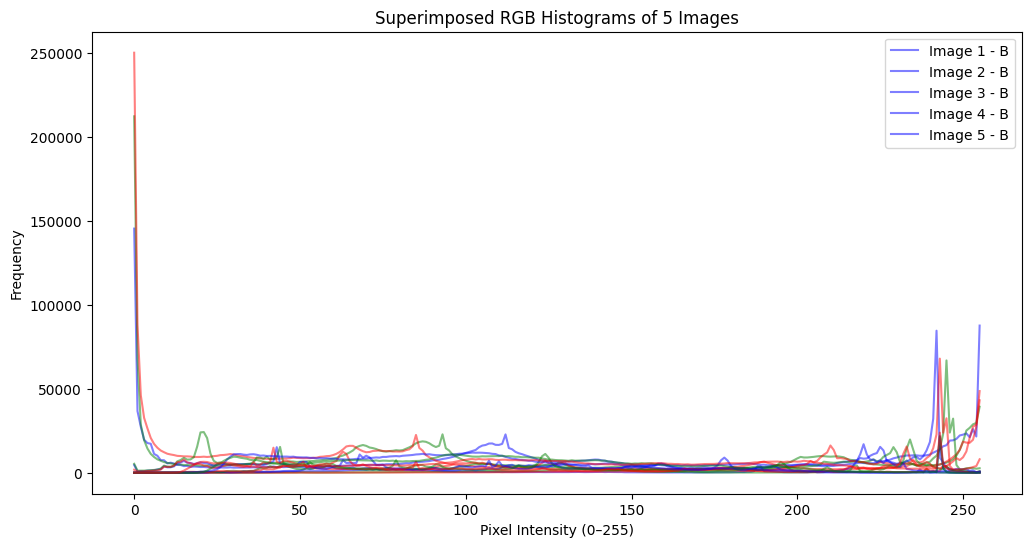

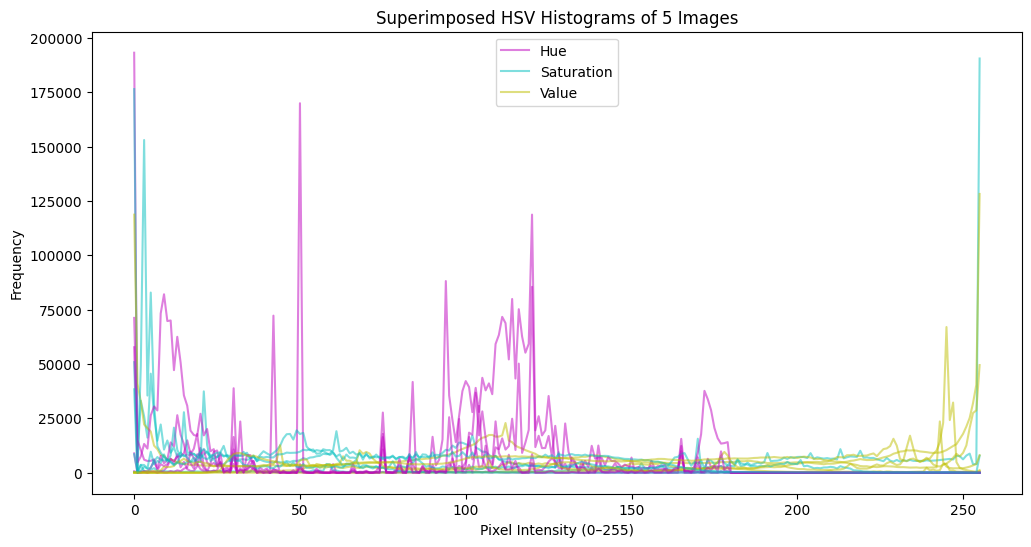

In [4]:
import cv2
import matplotlib.pyplot as plt
import glob
import os

image_paths = glob.glob(os.path.join("img", "*.*"))[:5] 
images = []

for p in image_paths:
    img = cv2.imread(p)
    if img is None:
        print(f"⚠️ Could not load {p}")
    else:
        images.append(img)

if len(images) < 5:
    raise ValueError("Not enough valid images in 'img' folder (need 5).")

colors = ("b", "g", "r")
plt.figure(figsize=(12, 6))

for idx, img in enumerate(images):
    for i, col in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=col, alpha=0.5,
                 label=f"Image {idx+1} - {col.upper()}" if i == 0 else "")

plt.title("Superimposed RGB Histograms of 5 Images")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
hsv_colors = ("m", "c", "y")  

for idx, img in enumerate(images):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    for i, col in enumerate(hsv_colors):
        hist = cv2.calcHist([hsv], [i], None, [256], [0, 256])
        plt.plot(hist, color=col, alpha=0.5,
                 label=f"Image {idx+1} - HSV[{i}]" if i == 0 else "")

plt.title("Superimposed HSV Histograms of 5 Images")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Frequency")
plt.legend(["Hue", "Saturation", "Value"])
plt.show()
